# Reproducing JPM’s US Rates Strategy RV Trade Idea 
## Note - `Treasuries: Does a less dovish Fed path usher in higher term premium?` (12 April 2024)
## `100:97 weighted 3.75% Apr-26/ 4.625% Sep-26 flatteners`

```
Turning to relative value, the recent volatility has presented opportunities at the front end of the curve. In particular, the 3.75% Apr-26s/ 4.625% Sep-26s curve appears 1.8bp too steep relative to the shape of the 2s/5s par curve (Figure 17). Hence, we recommend initiating 100:97 weighted 3.75% Apr-26/ 4.625% Sep-26 flatteners.
```

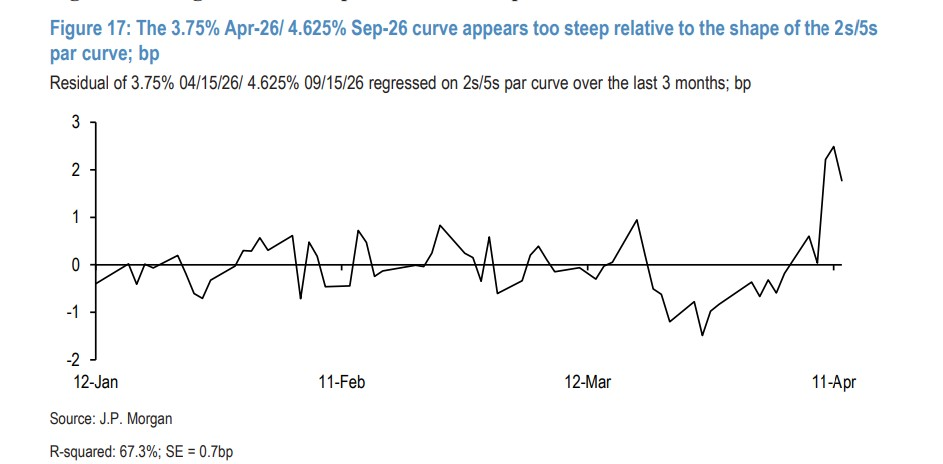

In [45]:
import sys
sys.path.append("../../")

In [46]:
from CurveInterpolator import GeneralCurveInterpolator
from CurveDataFetcher import CurveDataFetcher
from utils.rv_utils import cusip_spread_rv_regression
from utils.viz import plot_usts
from models.calibrate import calibrate_mles_ols, calibrate_nss_ols
from models.NelsonSiegelSvensson import NelsonSiegelSvenssonCurve

In [47]:
import pandas as pd
import numpy as np
import scipy
from datetime import datetime
from typing import Dict, List
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "axes.titlesize": "x-large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

import seaborn as sns
sns.set(style="whitegrid", palette="dark")

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import plotly
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True)

In [49]:
quote_type = "eod"
as_of_date = datetime(2024, 4, 12)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
    use_github=True,
)

curve_set_df

cusip security_type auction_date issue_date maturity_date  \
0    912797JN8          Bill   2024-03-14 2024-03-19    2024-04-16   
1    912797JP3          Bill   2024-03-21 2024-03-26    2024-04-23   
2    912797JQ1          Bill   2024-03-28 2024-04-02    2024-04-30   
3    912797JV0          Bill   2024-04-04 2024-04-09    2024-05-07   
4    912797JW8          Bill   2024-03-14 2024-03-19    2024-05-14   
..         ...           ...          ...        ...           ...   
383  912810TN8          Bond   2023-04-13 2023-04-17    2053-02-15   
384  912810TR9          Bond   2023-07-13 2023-07-17    2053-05-15   
385  912810TT5          Bond   2023-10-12 2023-10-16    2053-08-15   
386  912810TV0          Bond   2024-01-11 2024-01-16    2053-11-15   
387  912810TX6          Bond   2024-03-13 2024-03-15    2054-02-15   

     time_to_maturity  int_rate  high_investment_rate is_on_the_run  \
0            0.010959       NaN                 5.375         False   
1            0.030137       NaN                 5.365         False   
2            0.049315       NaN                 5.381         False   
3            0.068493       NaN                 5.360          True   
4            0.087671       NaN                 5.393         False   
..                ...       ...                   ...           ...   
383         28.865753     3.625                   NaN         False   
384         29.109589     3.625                   NaN         False   
385         29.361644     4.125                   NaN         False   
386         29.613699     4.750                   NaN         False   
387         29.865753     4.250                   NaN          True   

         ust_label  ...      parValue percentOutstanding  est_outstanding_amt  \
0    5.375% Apr-24  ...  8.004506e+08           0.003311         2.417805e+11   
1    5.365% Apr-24  ...  8.036739e+08           0.003467         2.317933e+11   
2    5.381% Apr-24  ...  6.621273e+08           0.002987         2.216449e+11   
3    5.360% May-24  ...  6.495379e+08           0.002998         2.166564e+11   
4    5.393% May-24  ...  3.774967e+08           0.002579         1.463749e+11   
..             ...  ...           ...                ...                  ...   
383  3.625% Feb-53  ...  9.367420e+09           0.141188         6.634703e+10   
384  3.625% May-53  ...  5.723292e+09           0.091264         6.271107e+10   
385  4.125% Aug-53  ...  8.606596e+09           0.120232         7.158330e+10   
386  4.750% Nov-53  ...  4.567153e+08           0.006874         6.644364e+10   
387  4.250% Feb-54  ...  1.848935e+09           0.037860         4.883608e+10   

     corpus_cusip outstanding_amt  portion_unstripped_amt  \
0             NaN    0.000000e+00                     NaN   
1             NaN    0.000000e+00                     NaN   
2             NaN    0.000000e+00                     NaN   
3             NaN    0.000000e+00                     NaN   
4             NaN    0.000000e+00                     NaN   
..            ...             ...                     ...   
383     912803GP2    6.634703e+10              53099246.7   
384     912803GS6    6.271107e+10              42925380.8   
385     912803GU1    7.158330e+10              62556573.0   
386     912803GW7    6.644364e+10              58846008.9   
387     912803GY3    4.883608e+10              46311497.8   

     portion_stripped_amt  reconstituted_amt  free_float  rank  
0            0.000000e+00                NaN   -800.4506  16.0  
1            0.000000e+00                NaN   -803.6739  15.0  
2            0.000000e+00                NaN   -662.1273  14.0  
3            0.000000e+00                NaN   -649.5379  13.0  
4            0.000000e+00                NaN   -377.4967  12.0  
..                    ...                ...         ...   ...  
383          1.324778e+10           718095.5  43731.8268   4.0  
384          1.978569e+10           584400.0  37202.0889   3.0  
385          9.026728e+0

## Build Par Curve Model

In [50]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):

    # remove OTRs, olds, double olds, triple olds
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"],  # TU
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"],  # Z3N
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"],  # FV
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"],  # TY
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"],  # TN
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"],  # US
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"],  # TWE
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"],  # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

    return curve_set_filtered_df


def no_filter(curve_set_df: pd.DataFrame):
    return curve_set_df

In [51]:
# filter and fit bspline w/ knots are liquidity points
curve_set_filtered_df = liquidity_premium_curve_set_filter(curve_set_df=curve_set_df)

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)

fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

nss_func, status_nss, _ = calibrate_nss_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_nss

mles_func, status_mles = calibrate_mles_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
    overnight_rate=5.31,
    N=9,
)

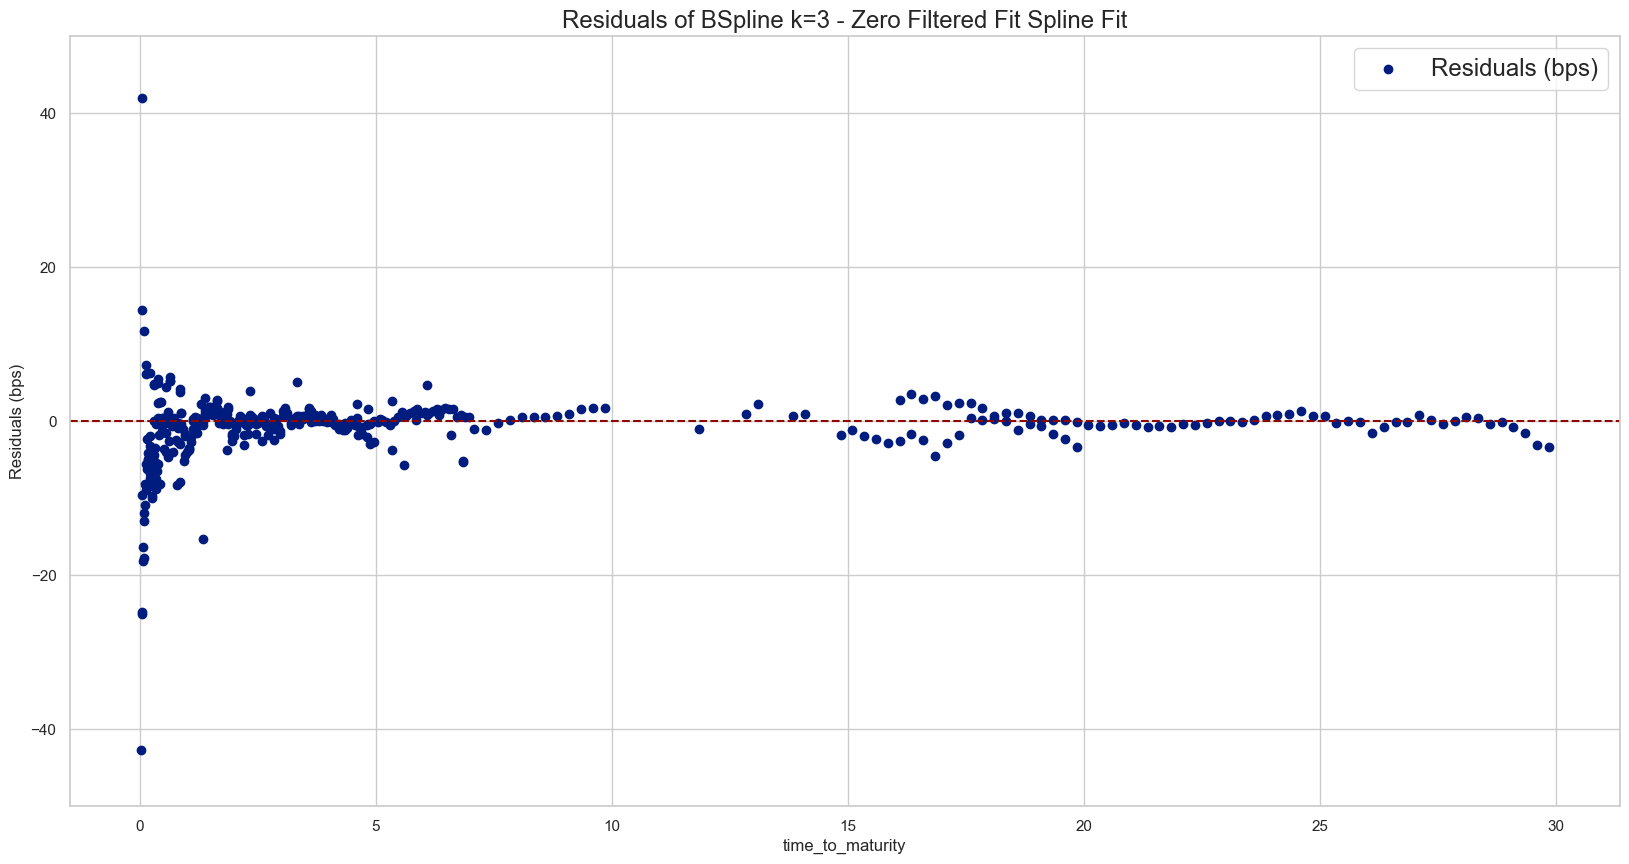

In [52]:
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"{quote_type}_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"{quote_type}_price",
        "free_float",
    ],
    ust_labels_highlighter=[
        ("3.750% Apr-26", "red"), ("4.625% Sep-26", "blue"), 
    ],
    zero_curves=[(fitted_bspline, "BSpline k=3 - Zero Filtered Fit"), (nss_func, "Nelson Siegel Svensson"), (mles_func, "Merrill Lynch Exponential Spline")],
    title=f"All USTs - using {f"{quote_type}_yield"} - as of {as_of_date}",
    y_axis_range=[4.3, 5.7]
)

## Fetching historical curve sets to regress 3.75% Apr-26s/ 4.625% Sep-26s vs our fitted model over time (2s/5s par curve)

In [53]:
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 4, 10)

curve_sets_dict_df, fitted_curves_dict = curve_data_fetcher.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[
        ("LPF", f"{quote_type}_yield", liquidity_premium_curve_set_filter),
        ("NSS", f"{quote_type}_yield", no_filter, calibrate_nss_ols),
    ],
)

AGGREGATING CURVE SET DFs: 100%|██████████| 92/92 [00:03<00:00, 23.61it/s]


In [54]:
cusip_timeseries: Dict[str, List[Dict[str, str | float | int]]] = {}
fitted_cubic_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_bspline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_smooth_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
nss_timeseries: Dict[datetime, NelsonSiegelSvenssonCurve] = {}

for dt in tqdm.tqdm(curve_sets_dict_df.keys(), desc="Main Loop"):
    fitted_cubic_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25],
        k=3,
        return_func=True,
    )
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25], k=5, return_func=True
    )
    fitted_smooth_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
    )
    curr_nss_model = fitted_curves_dict[dt]["NSS"]

    fitted_cubic_spline_timeseries[dt] = fitted_cubic_spline
    fitted_bspline_timeseries[dt] = fitted_bspline
    fitted_smooth_spline_timeseries[dt] = fitted_smooth_spline 
    nss_timeseries[dt] = curr_nss_model

    curr_curve_set_df = curve_sets_dict_df[dt]
    curr_curve_set_df["lpf_cubic_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_cubic_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_bspline_spread"] = curr_curve_set_df["eod_yield"] - fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_smooth_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_smooth_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["nf_nss_spread"] = curr_curve_set_df.apply(
        lambda row: row["eod_yield"] - curr_nss_model(row["time_to_maturity"])
        if pd.notna(row["eod_yield"]) and curr_nss_model(row["time_to_maturity"]) is not None
        else np.nan, axis=1
    )

    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_timeseries:
            cusip_timeseries[row["cusip"]] = []

        payload = {
            "Date": dt,
            "cusip": row["cusip"],
            f"{quote_type}_yield": row[f"{quote_type}_yield"],
            f"{quote_type}_price": row[f"{quote_type}_price"],
            "lpf_cubic_spline_spread": row["lpf_cubic_spline_spread"],
            "lpf_bspline_spread": row["lpf_bspline_spread"],
            "lpf_smooth_spline_spread": row["lpf_smooth_spline_spread"],
            "nf_nss_spread": row["nf_nss_spread"],
            "free_float": row["free_float"],
            "est_outstanding_amount": row["est_outstanding_amt"],
            "soma_holdings": row["parValue"],
            "soma_holdings_percent_outstanding": row["percentOutstanding"],
            "stripped_amount": row["portion_stripped_amt"],
            "reconstituted_amount": row["reconstituted_amt"],
            "lpf_cubic_spline": fitted_cubic_spline,
            "lpf_bspline": fitted_bspline,
            "lpf_smooth_spline": fitted_smooth_spline,
            "nf_nss": curr_nss_model,
        }
        
        cusip_timeseries[row["cusip"]].append(payload)

Main Loop: 100%|██████████| 70/70 [00:02<00:00, 30.79it/s]


In [55]:
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(start_date=start_date, end_date=end_date)
ct_yields_df

Date  CT2M      CT3M      CT6M       CT1       CT2       CT3  \
0  2024-01-02   NaN  5.414579  5.266761  4.812030  4.332596  4.100865   
1  2024-01-03   NaN  5.403556  5.277076  4.822615  4.332576  4.077939   
2  2024-01-04   NaN  5.403156  5.250537  4.855018  4.382398  4.145585   
3  2024-01-05   NaN  5.391337  5.238747  4.854037  4.399235  4.178916   
4  2024-01-08   NaN  5.390940  5.227726  4.831904  4.365890  4.121773   
..        ...   ...       ...       ...       ...       ...       ...   
65 2024-04-04   NaN  5.373238  5.348941  5.022444  4.649279  4.465782   
66 2024-04-05   NaN  5.382595  5.369280  5.064586  4.733240  4.546828   
67 2024-04-08   NaN  5.382196  5.379642  5.085891  4.783829  4.604838   
68 2024-04-09   NaN  5.312104  5.326863  5.152263  4.935888  4.791008   
69 2024-04-10   NaN  5.415888  5.421877  5.204843  4.970175  4.803073   

         CT5       CT7      CT10      CT20      CT30  
0   3.930802  3.951168  3.943937  4.247731  4.083212  
1   3.895921  3.914869  3.906323  4.209600  4.052949  
2   3.972914  3.992895  3.988823  4.295010  4.137418  
3   4.015292  4.040103  4.048999  4.363246  4.207898  
4   3.966166  3.993101  4.010992  4.322075  4.176737  
..       ...       ...       ...       ...       ...  
65  4.300537  4.307803  4.308815  4.574195  4.468574  
66  4.378591  4.392378  4.388936  4.647449  4.541568  
67  4.428457  4.429570  4.417144  4.654829  4.549541  
68  4.607524  4.600711  4.563138  4.776680  4.650411  
69  4.607708  4.590076  4.555092  4.759129  4.634122  

[70 rows x 12 columns]

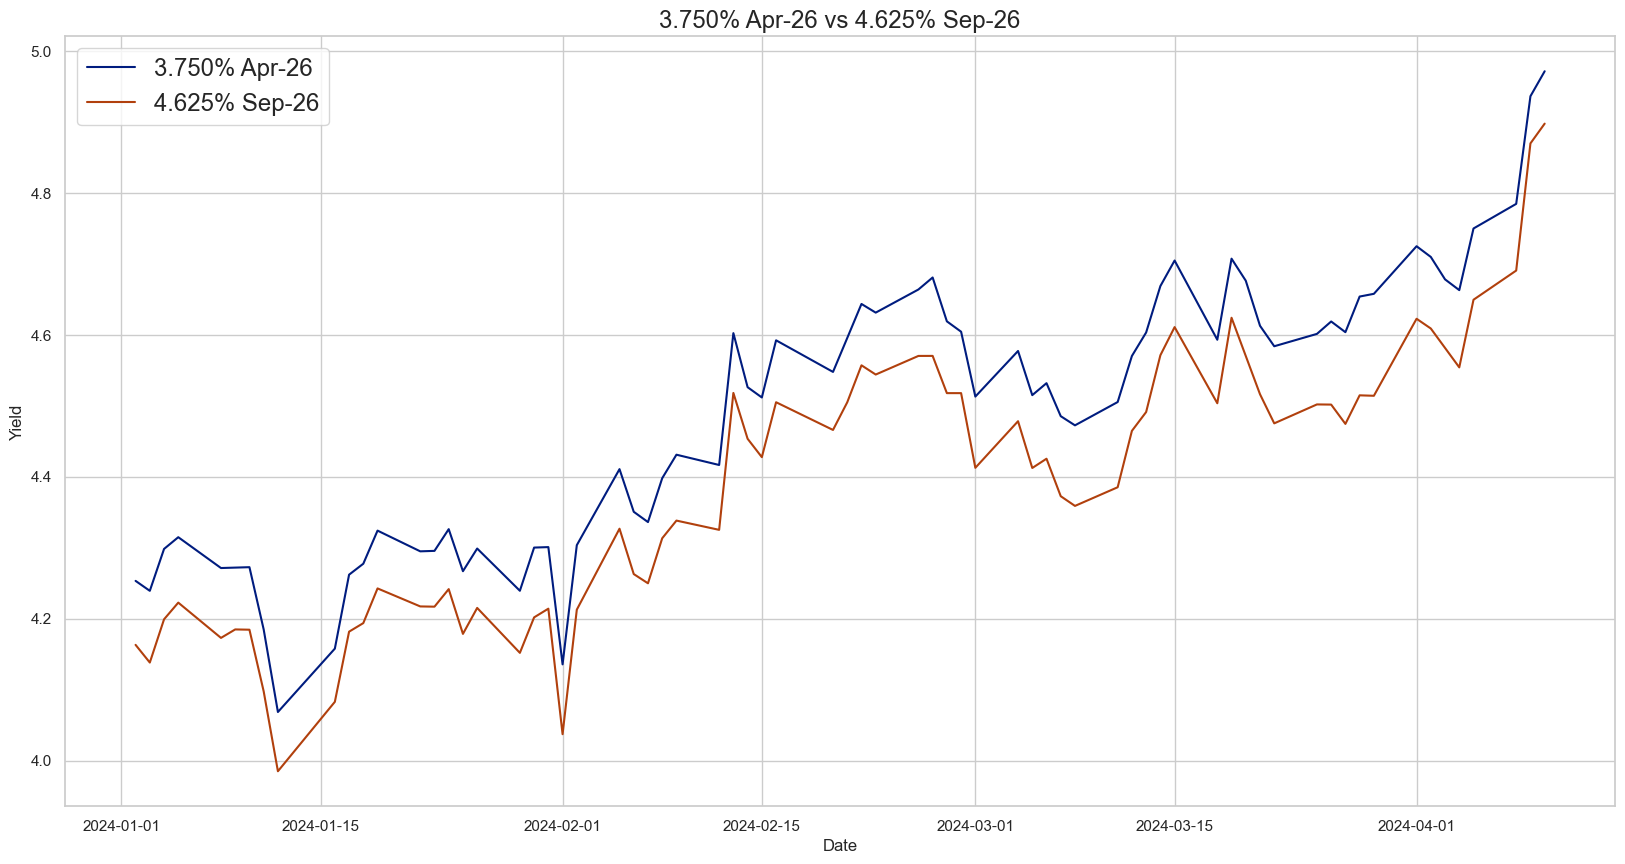

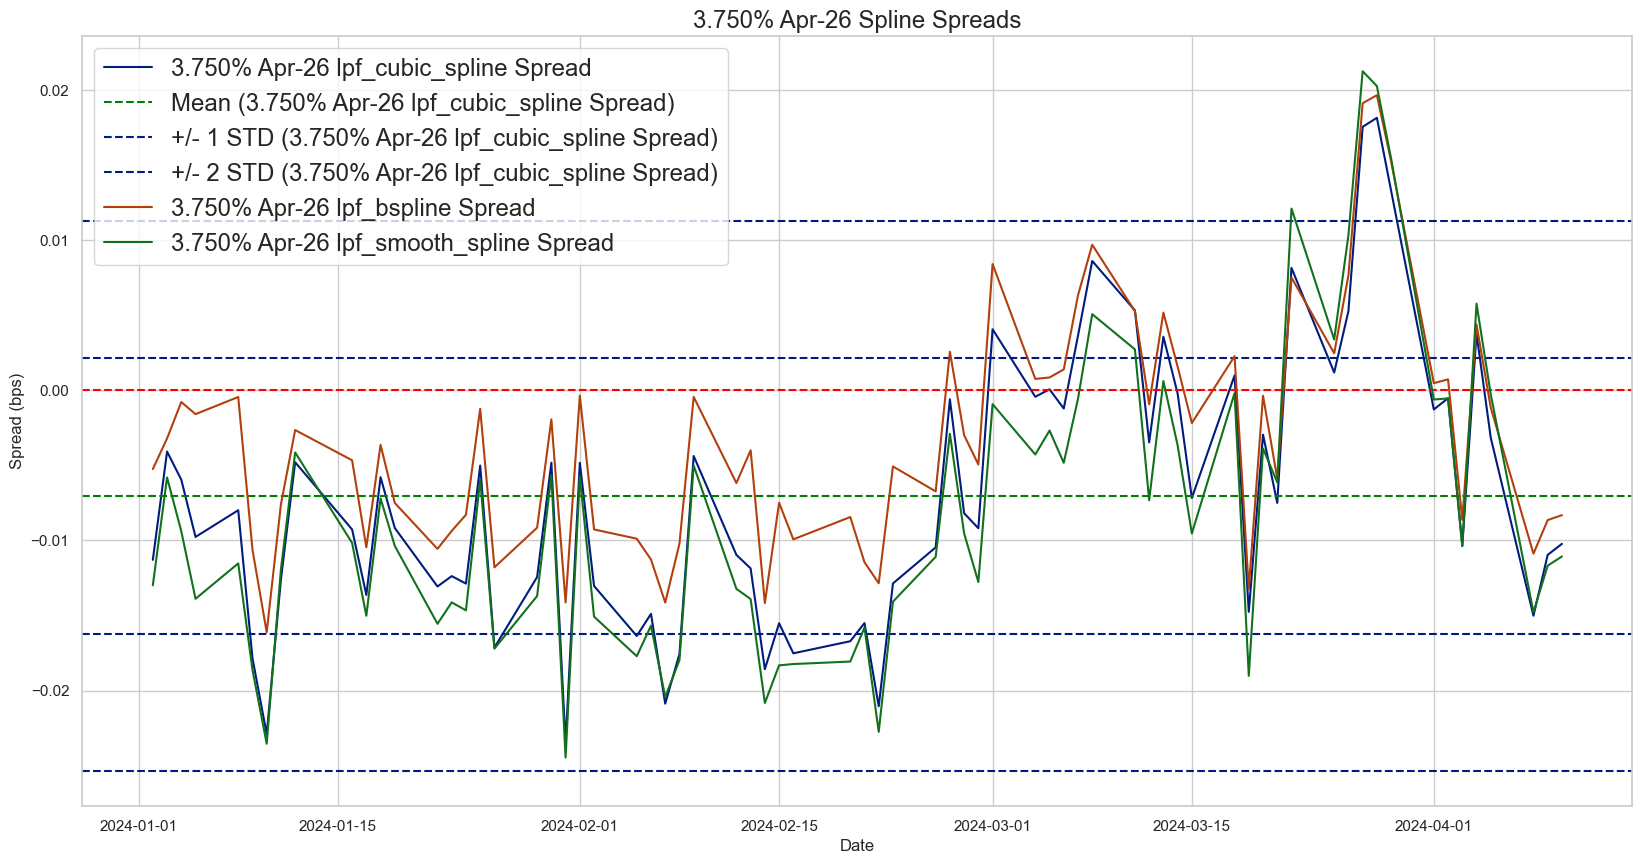

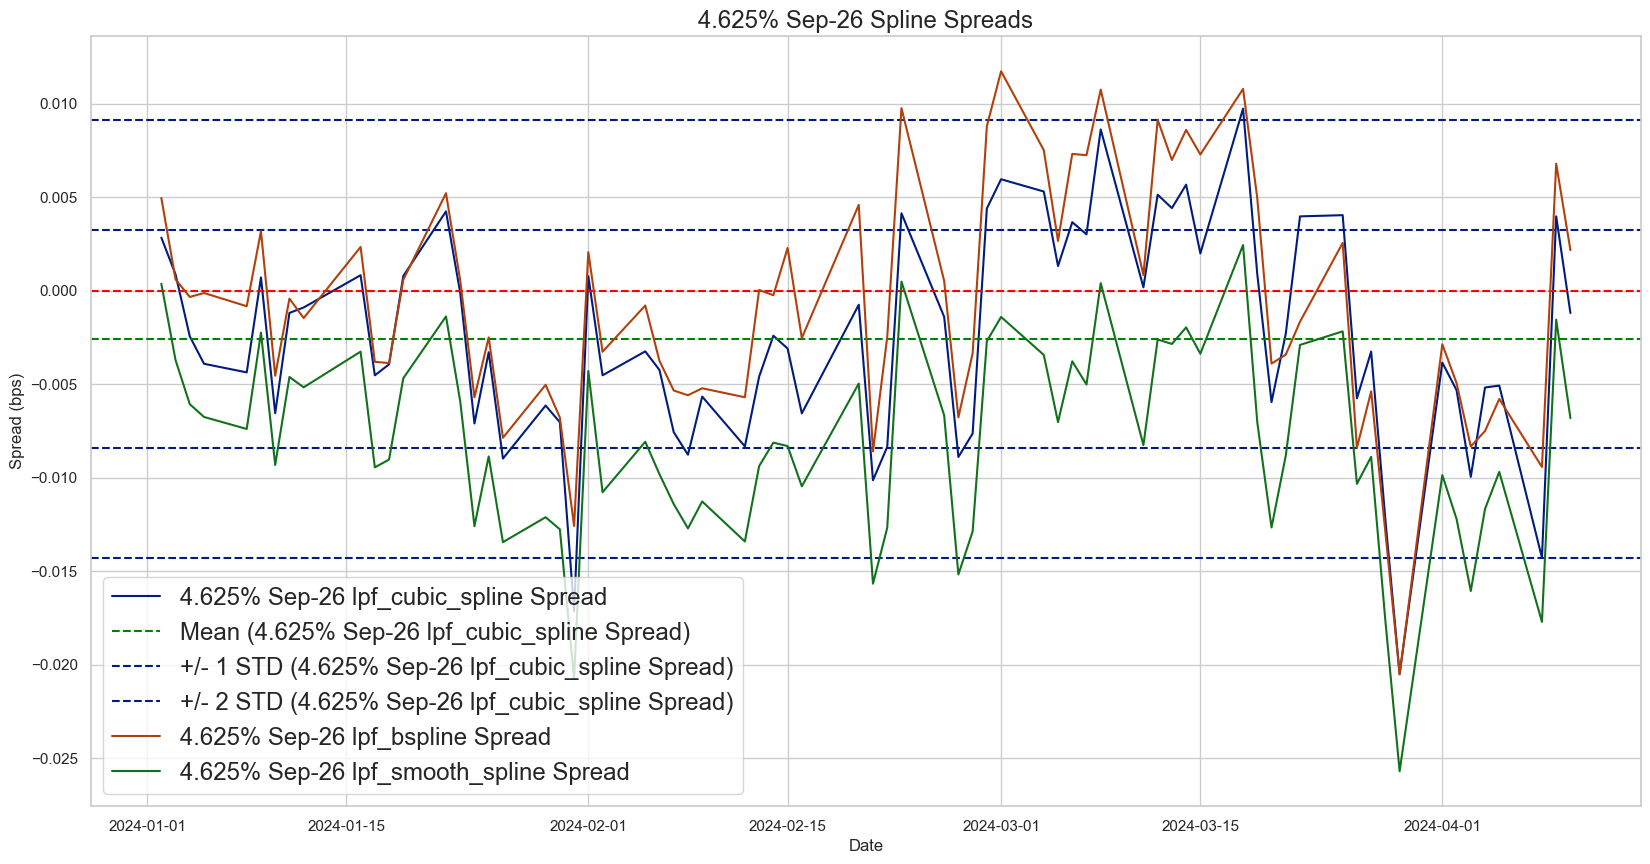

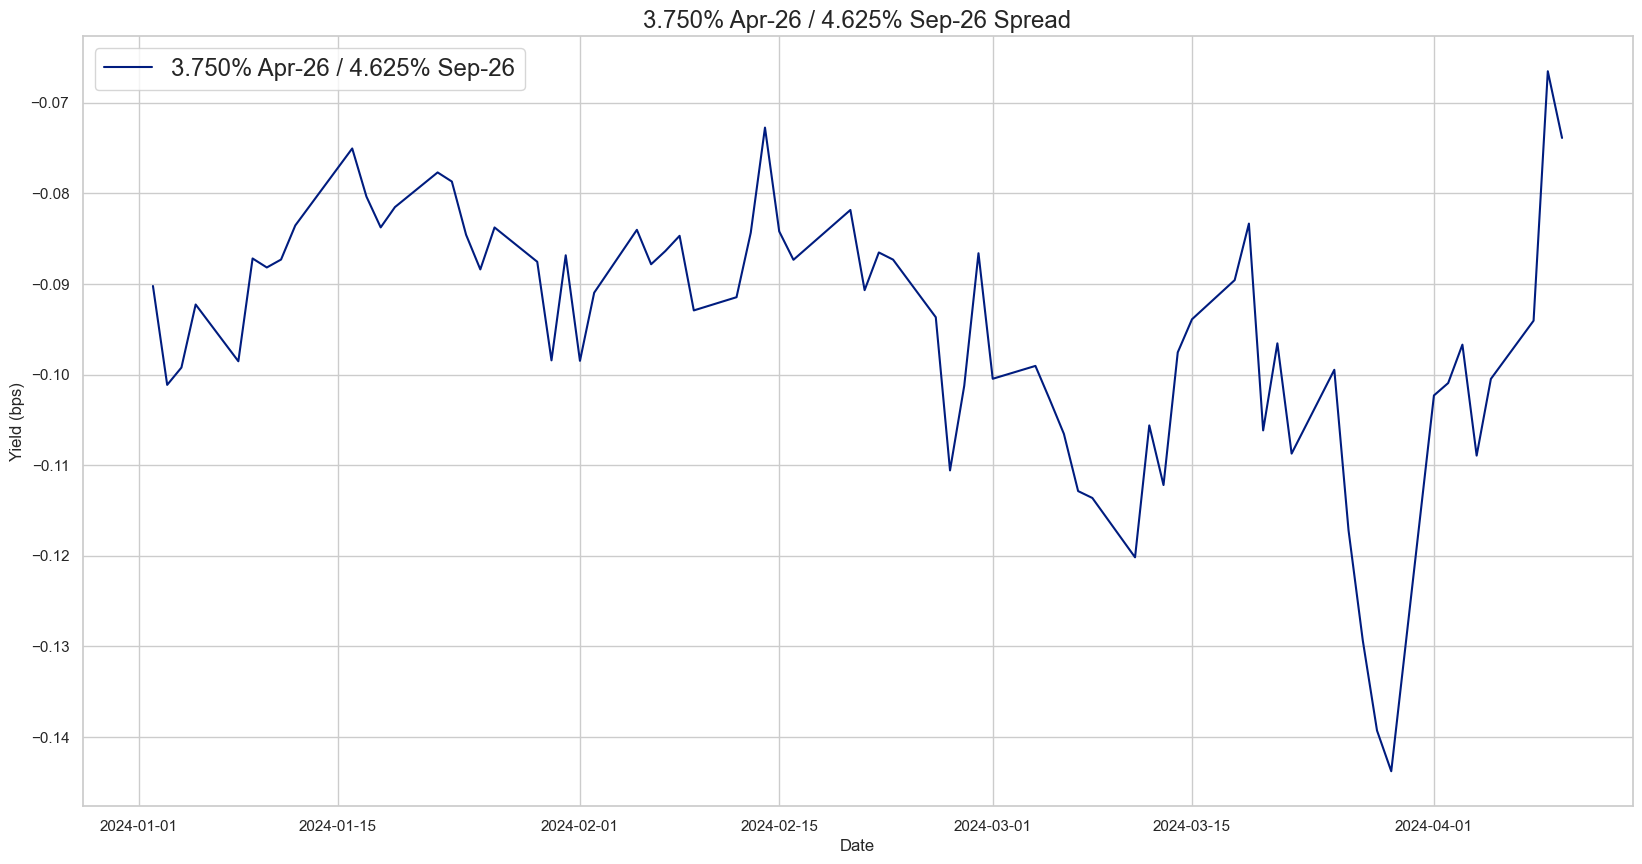

lpf_cubic_spline is Benchmark Spline


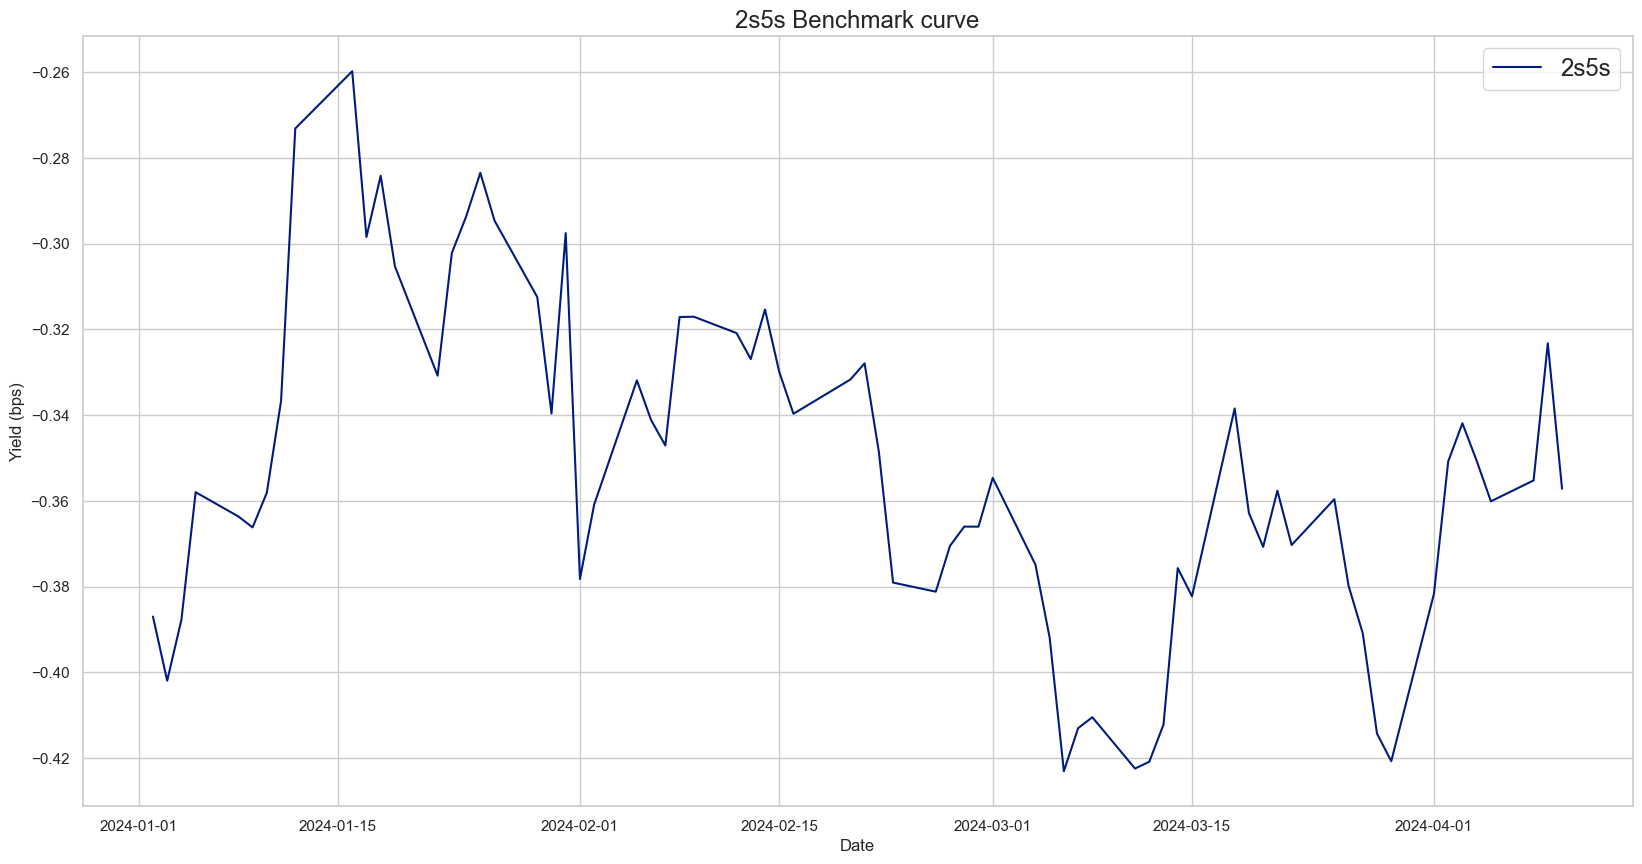

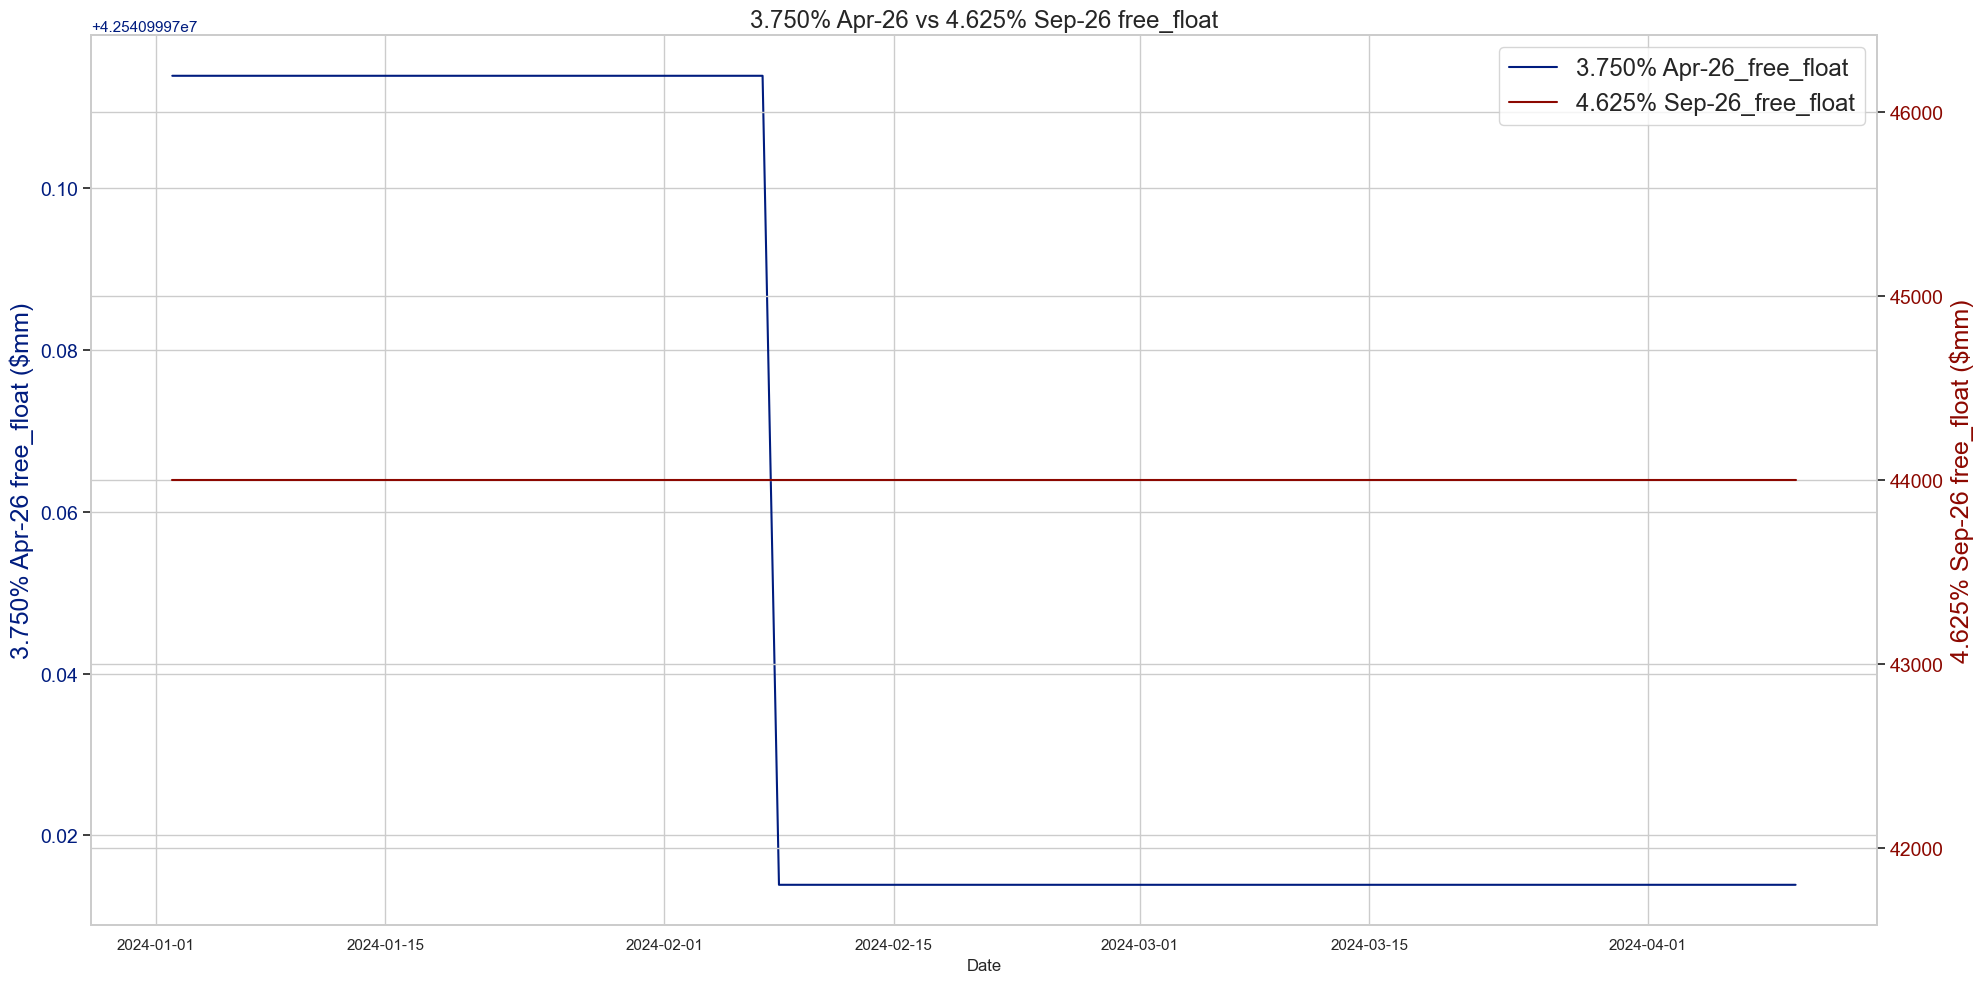

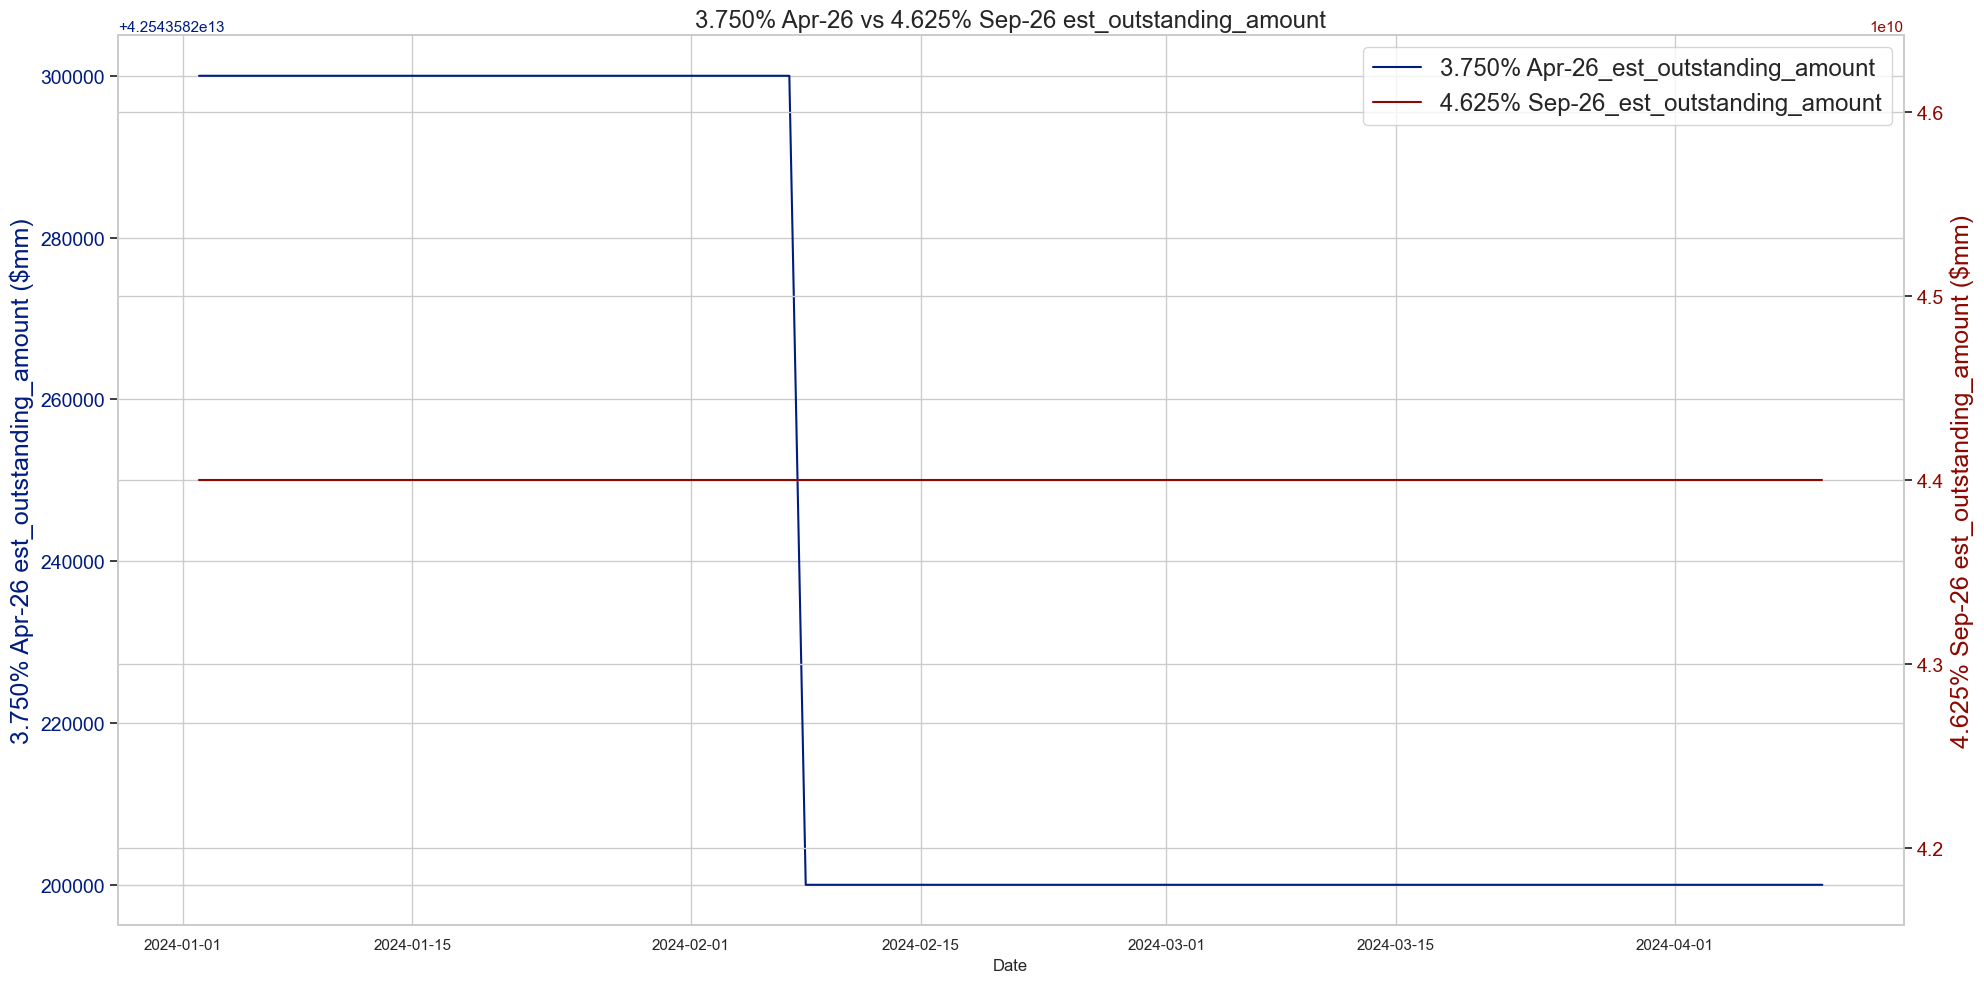

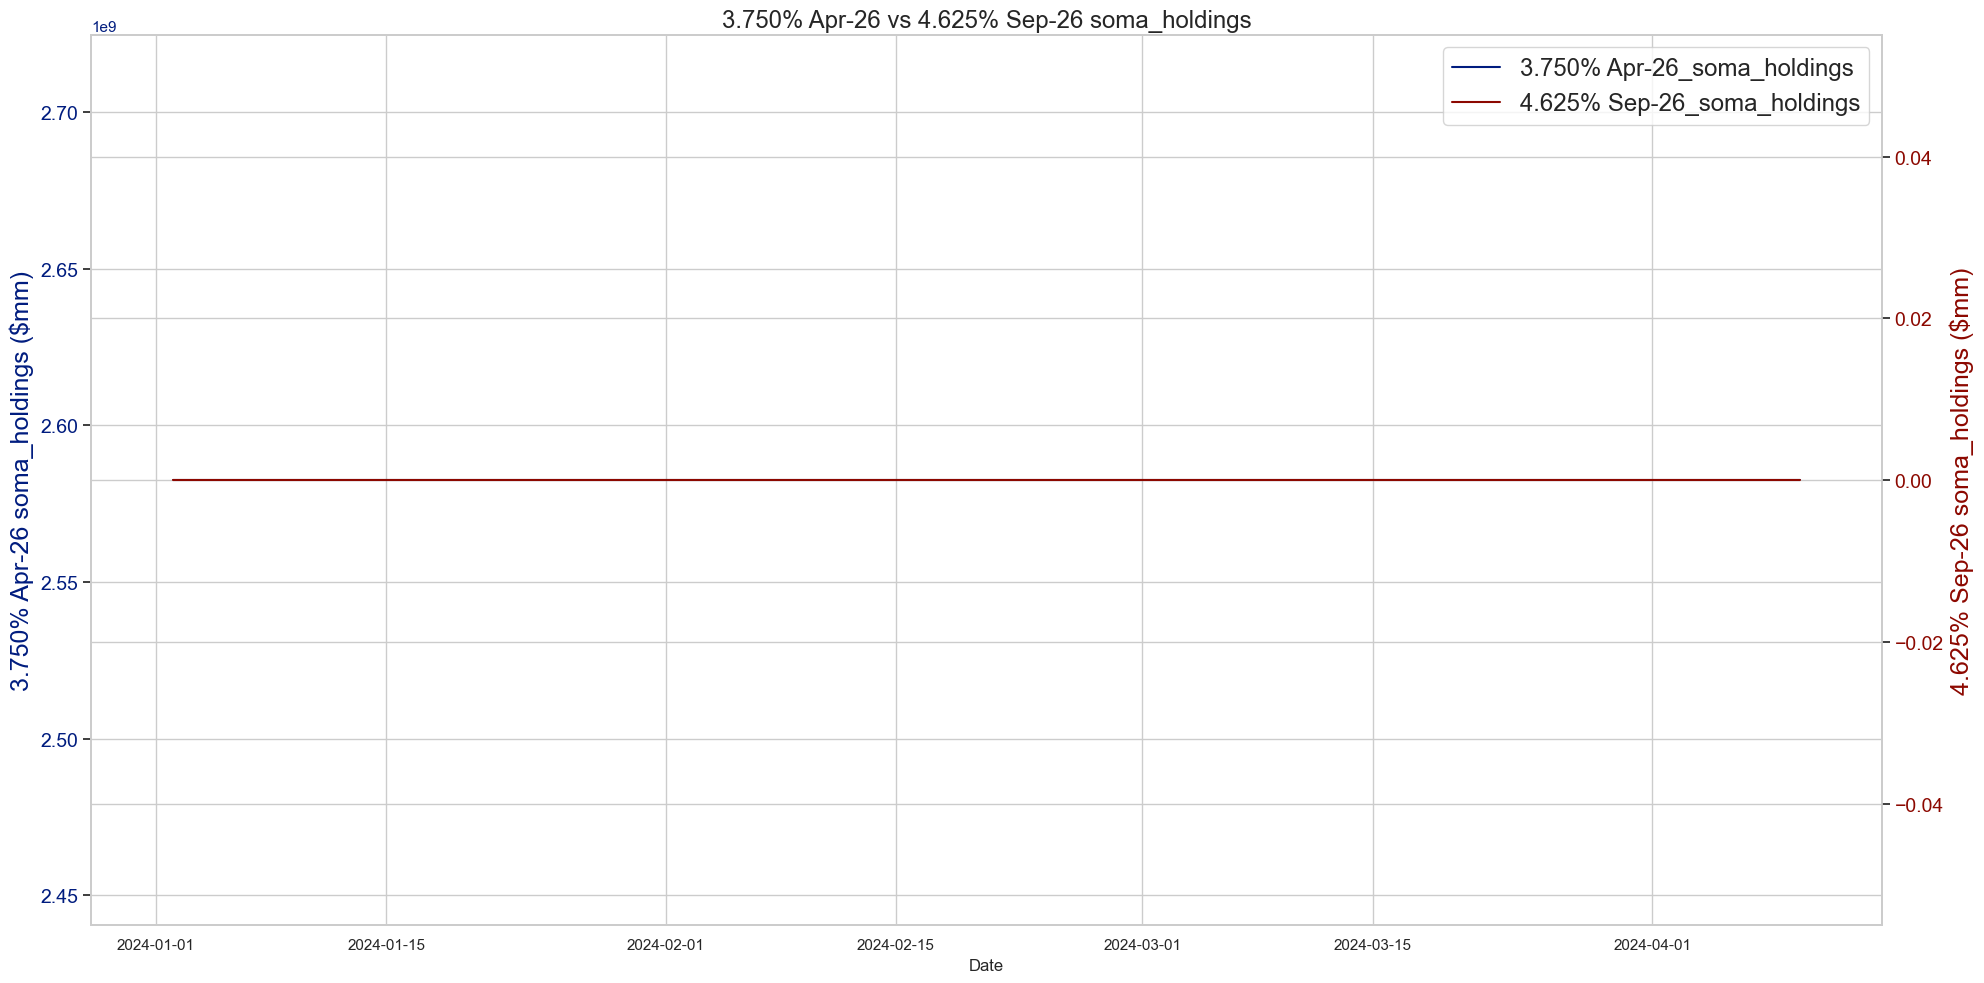

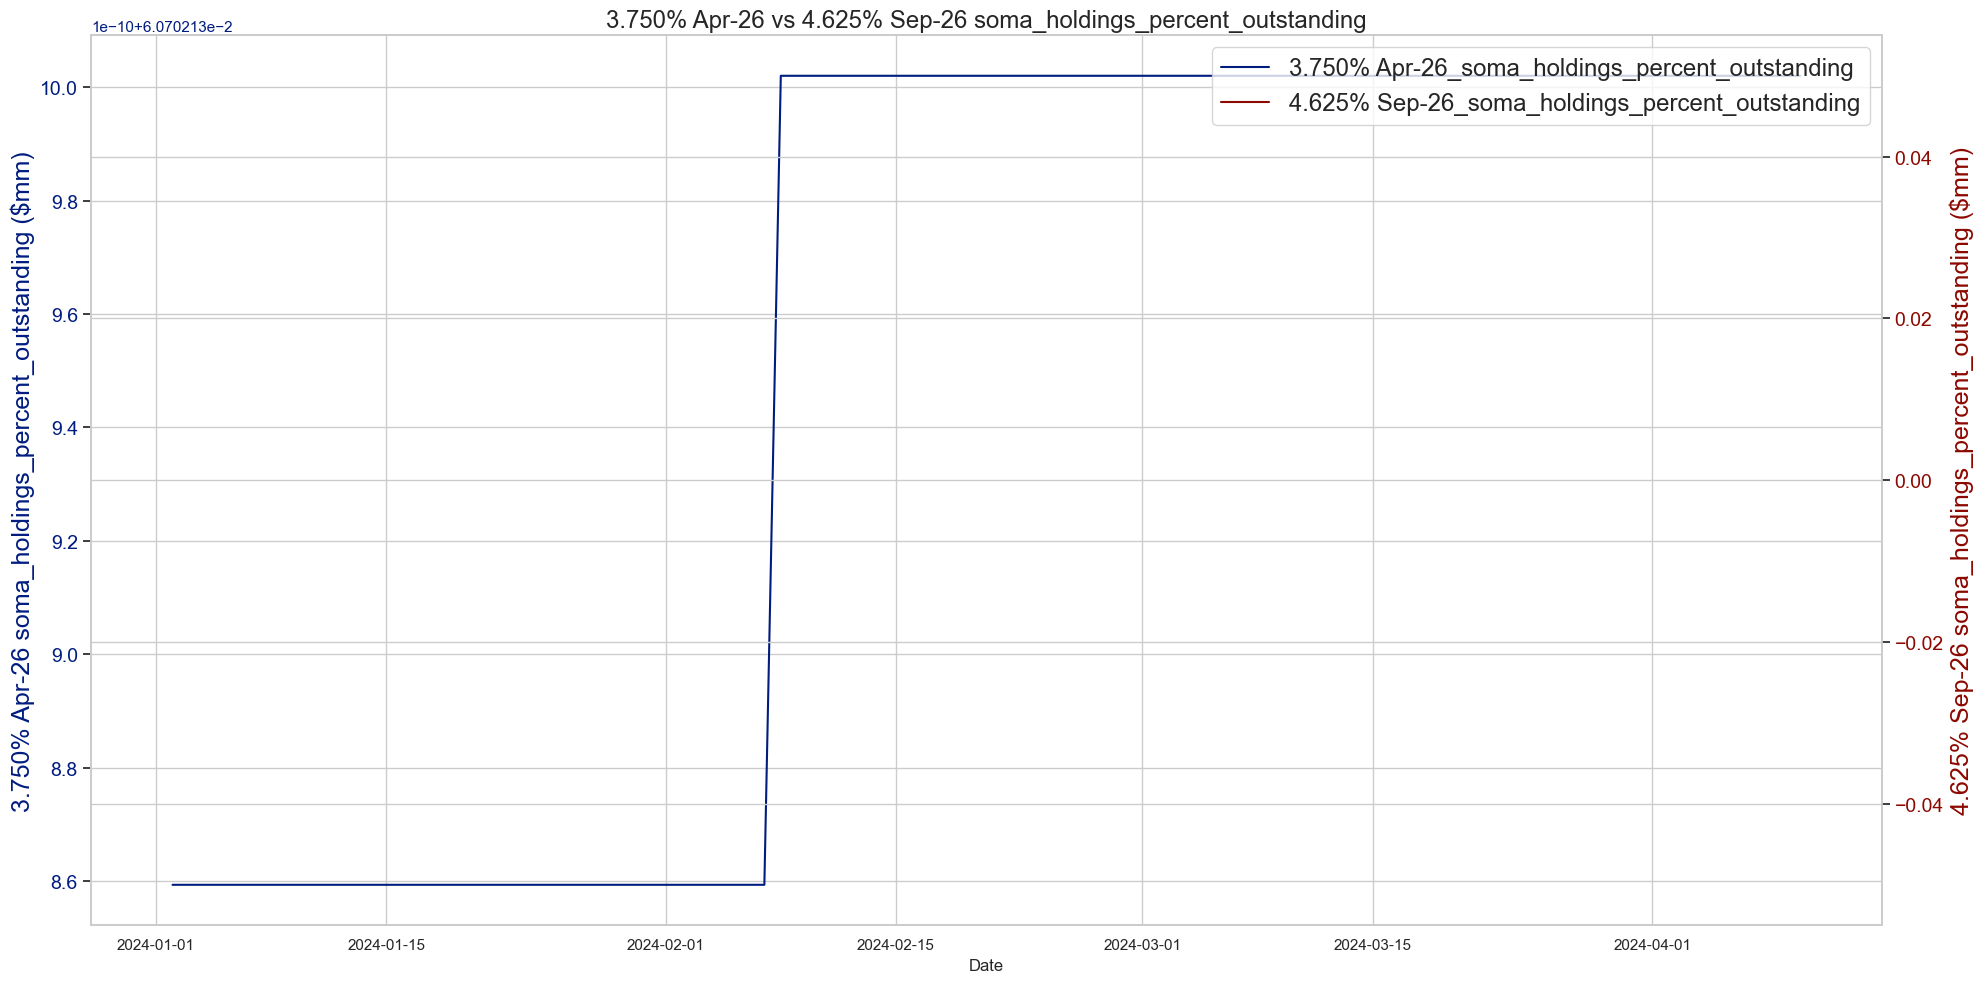

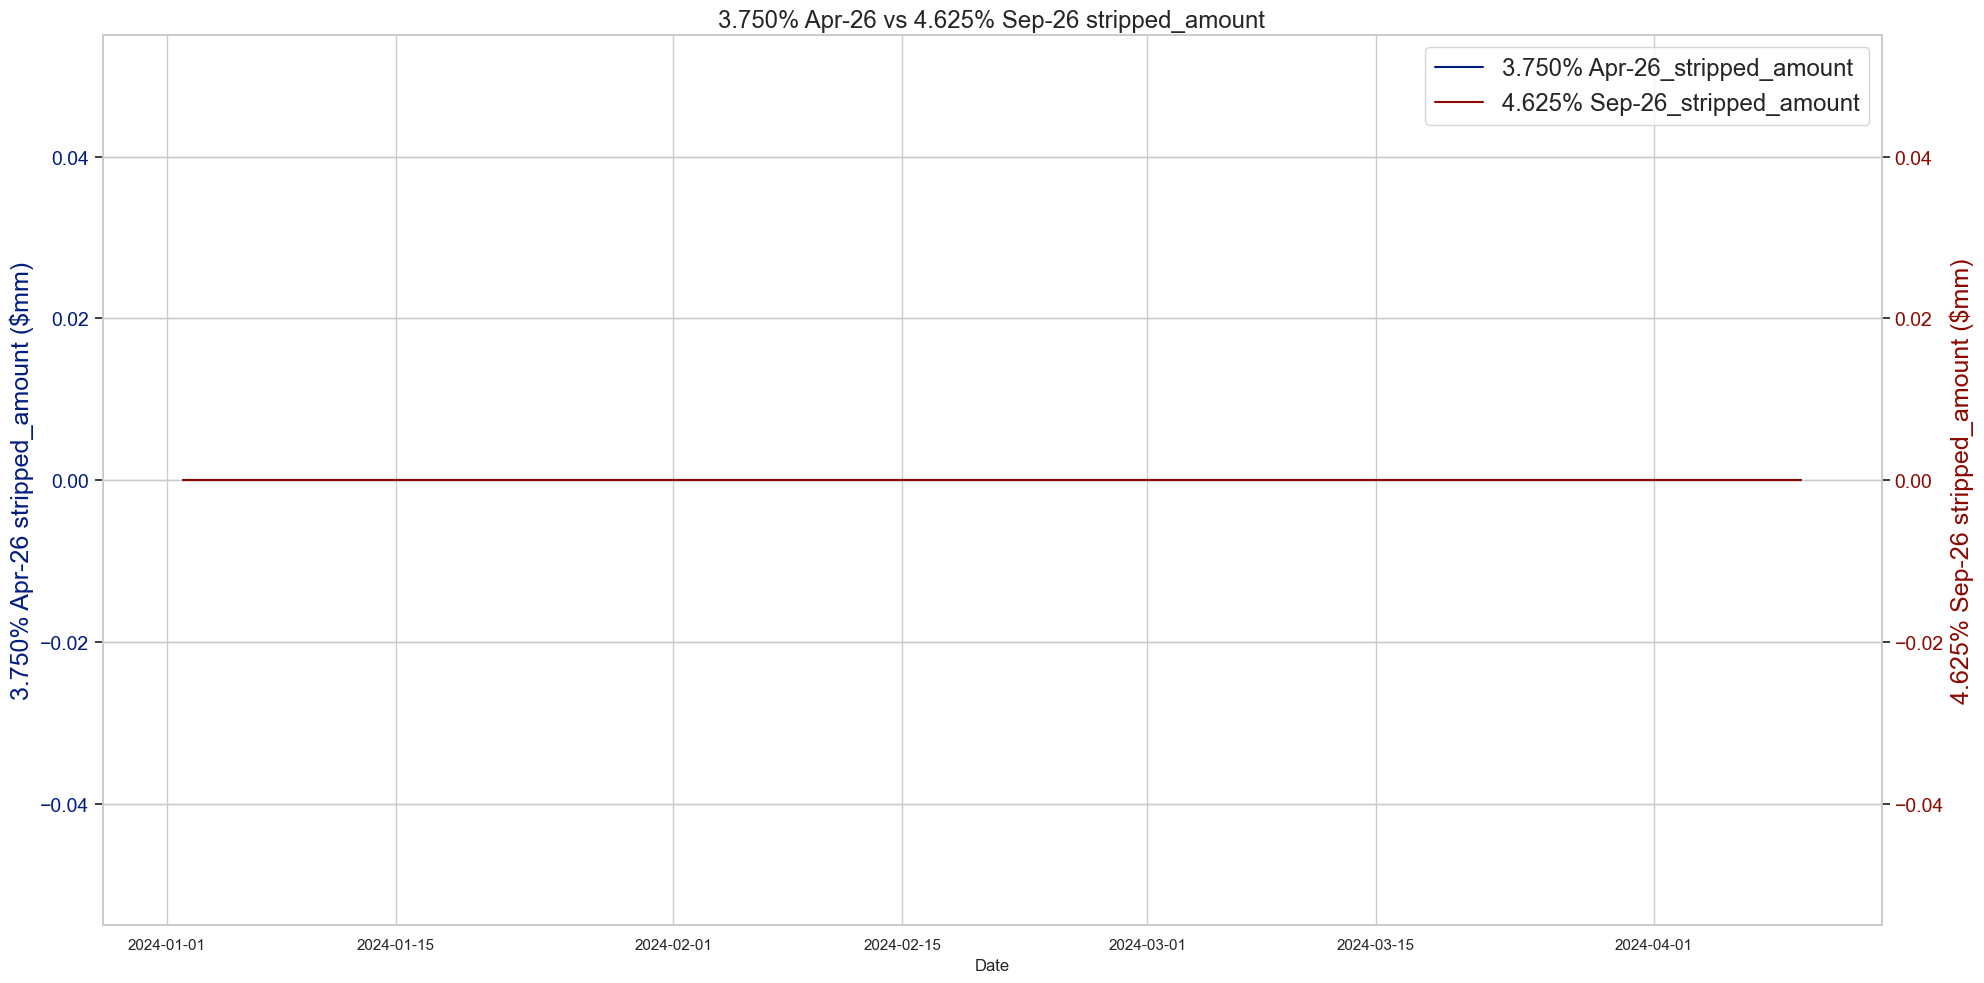

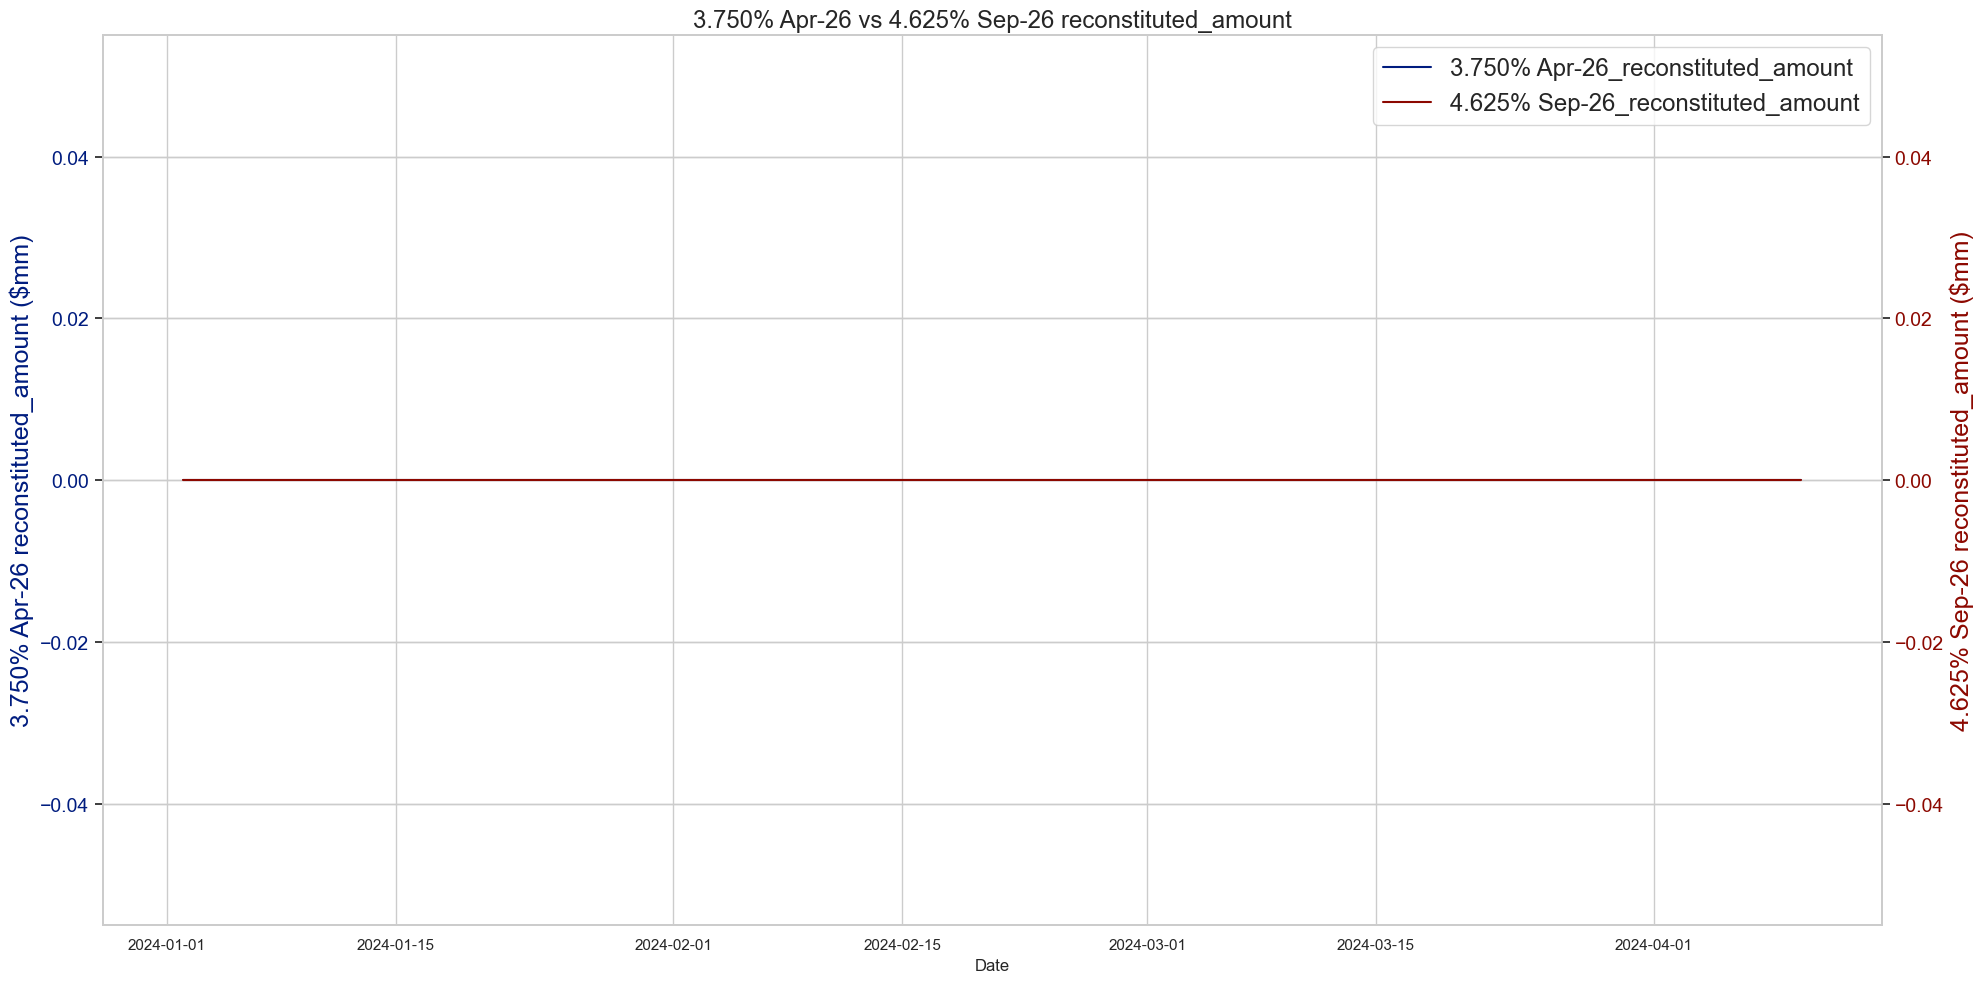

                                  OLS Regression Results                                 
Dep. Variable:     3.750% Apr-26 / 4.625% Sep-26   R-squared:                       0.537
Model:                                       OLS   Adj. R-squared:                  0.531
Method:                            Least Squares   F-statistic:                     78.98
Date:                           Sun, 06 Oct 2024   Prob (F-statistic):           5.40e-13
Time:                                   19:03:49   Log-Likelihood:                 225.27
No. Observations:                             70   AIC:                            -446.5
Df Residuals:                                 68   BIC:                            -442.0
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------

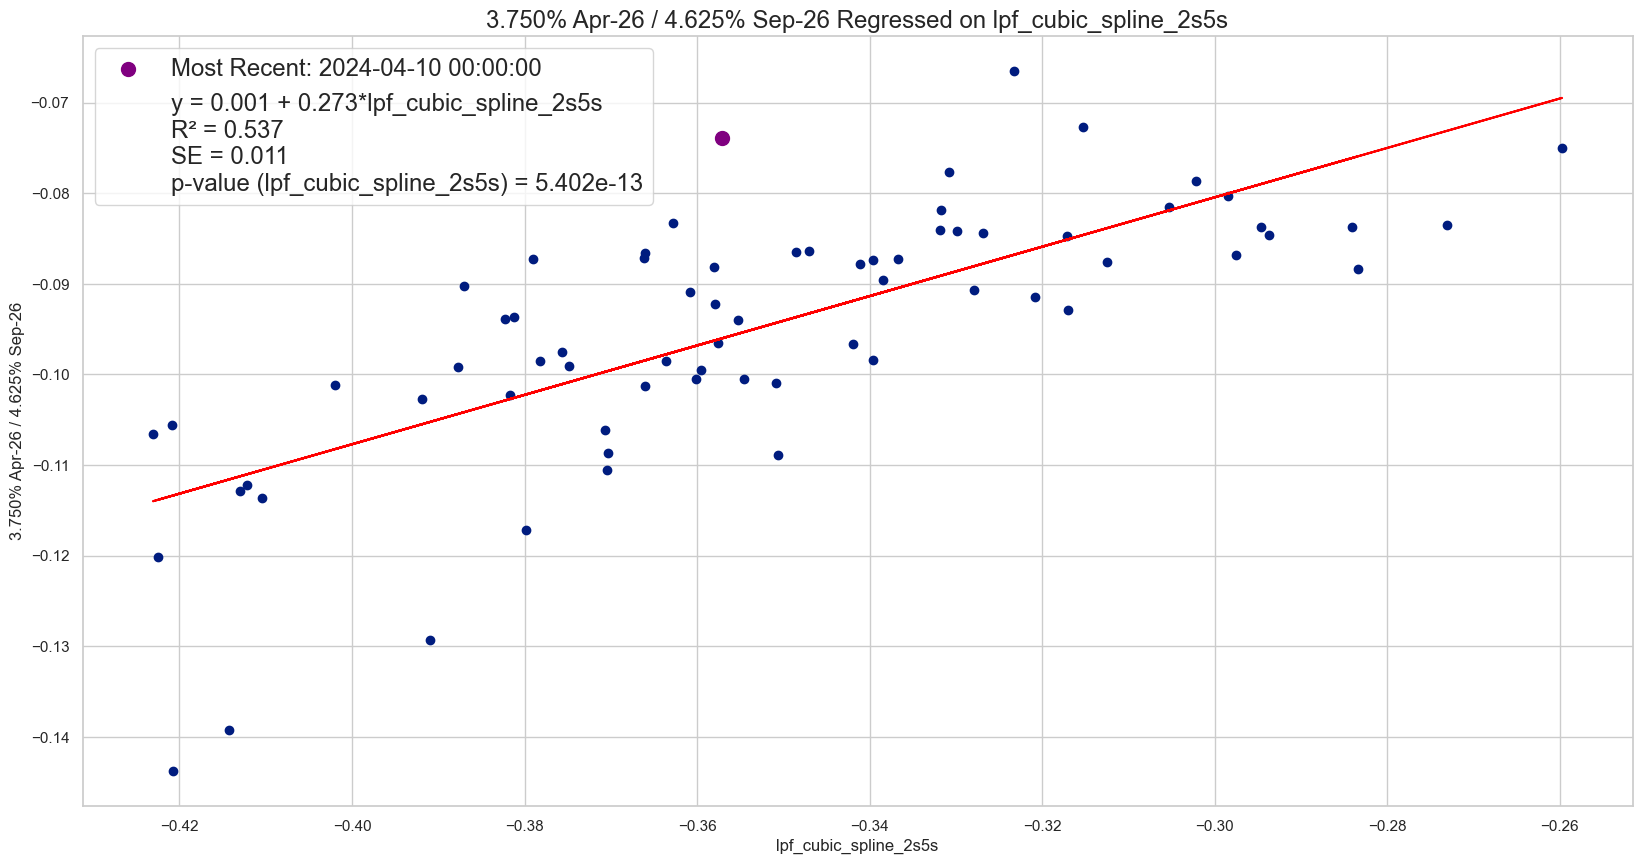

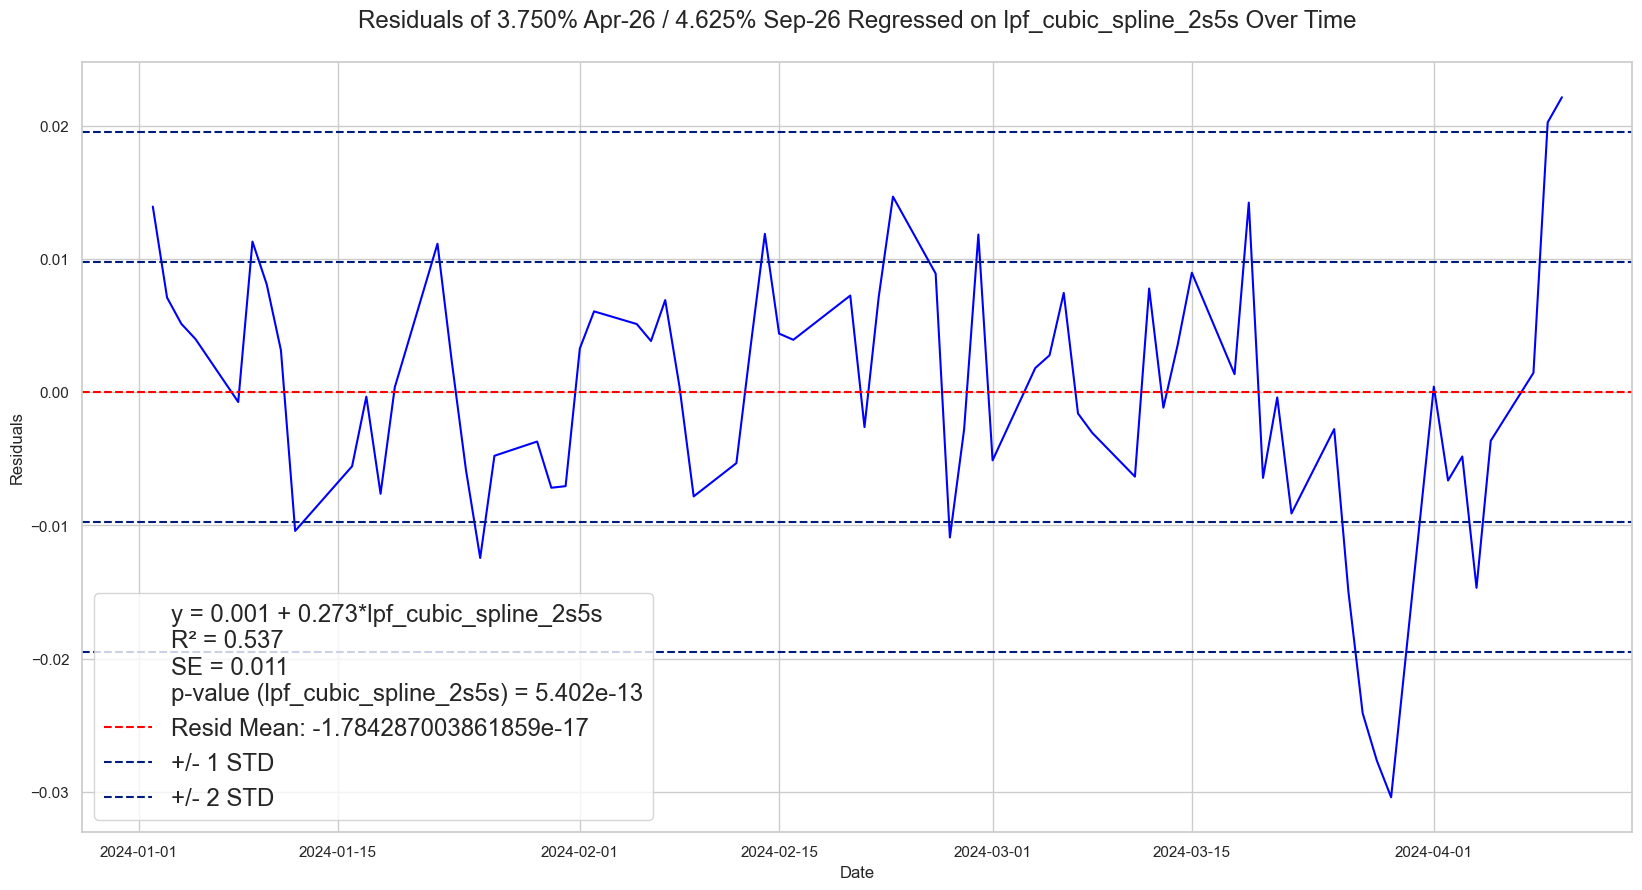

                                  OLS Regression Results                                 
Dep. Variable:     3.750% Apr-26 / 4.625% Sep-26   R-squared:                       0.549
Model:                                       OLS   Adj. R-squared:                  0.542
Method:                            Least Squares   F-statistic:                     82.67
Date:                           Sun, 06 Oct 2024   Prob (F-statistic):           2.30e-13
Time:                                   19:03:50   Log-Likelihood:                 226.13
No. Observations:                             70   AIC:                            -448.3
Df Residuals:                                 68   BIC:                            -443.8
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

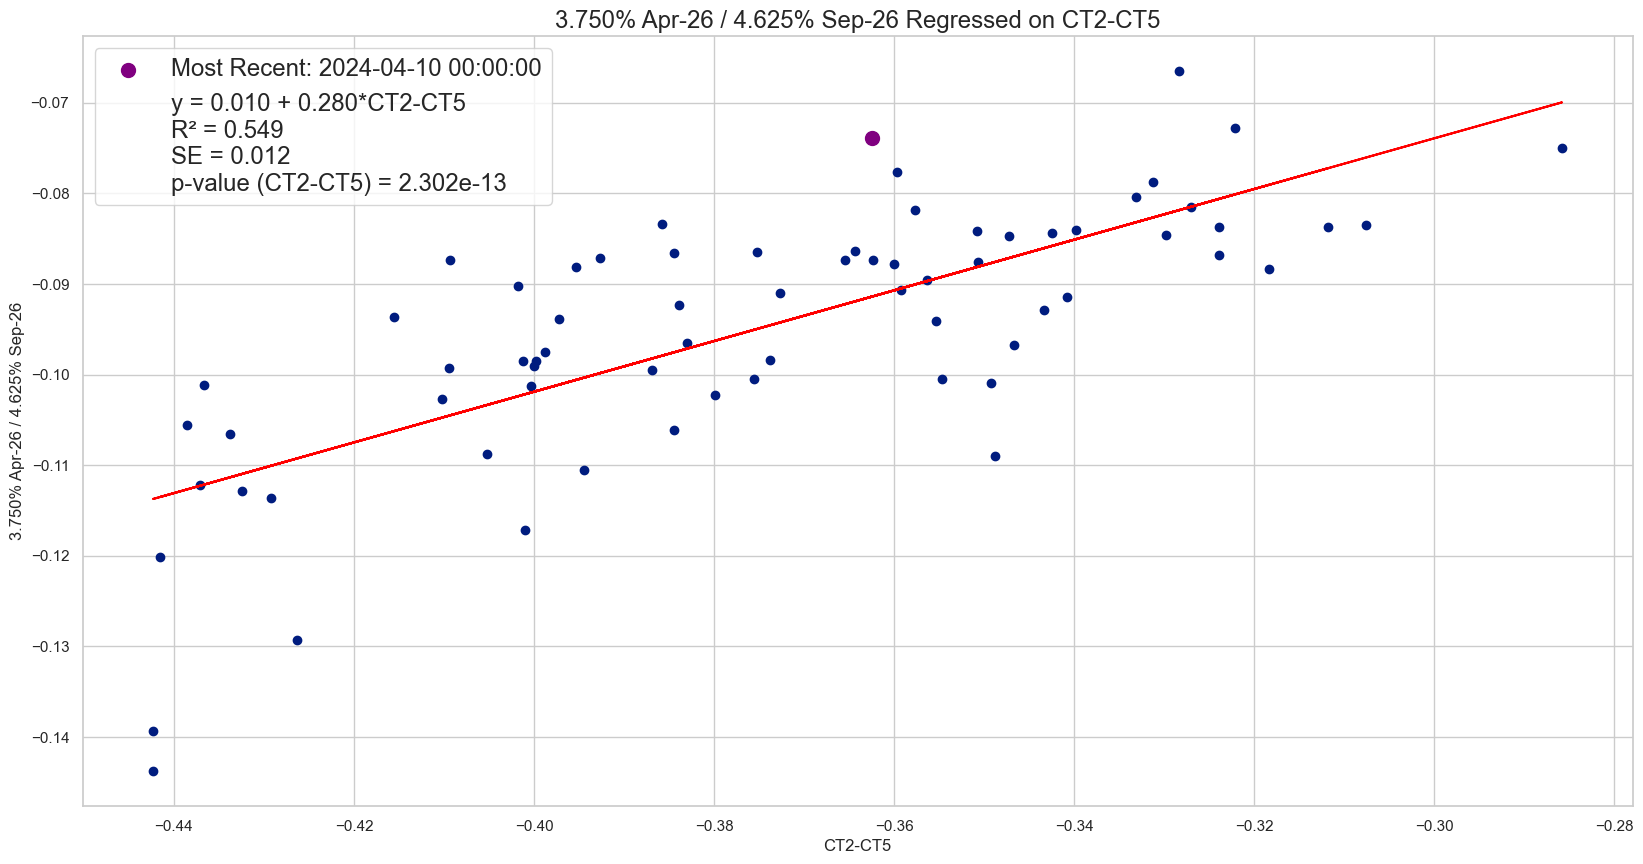

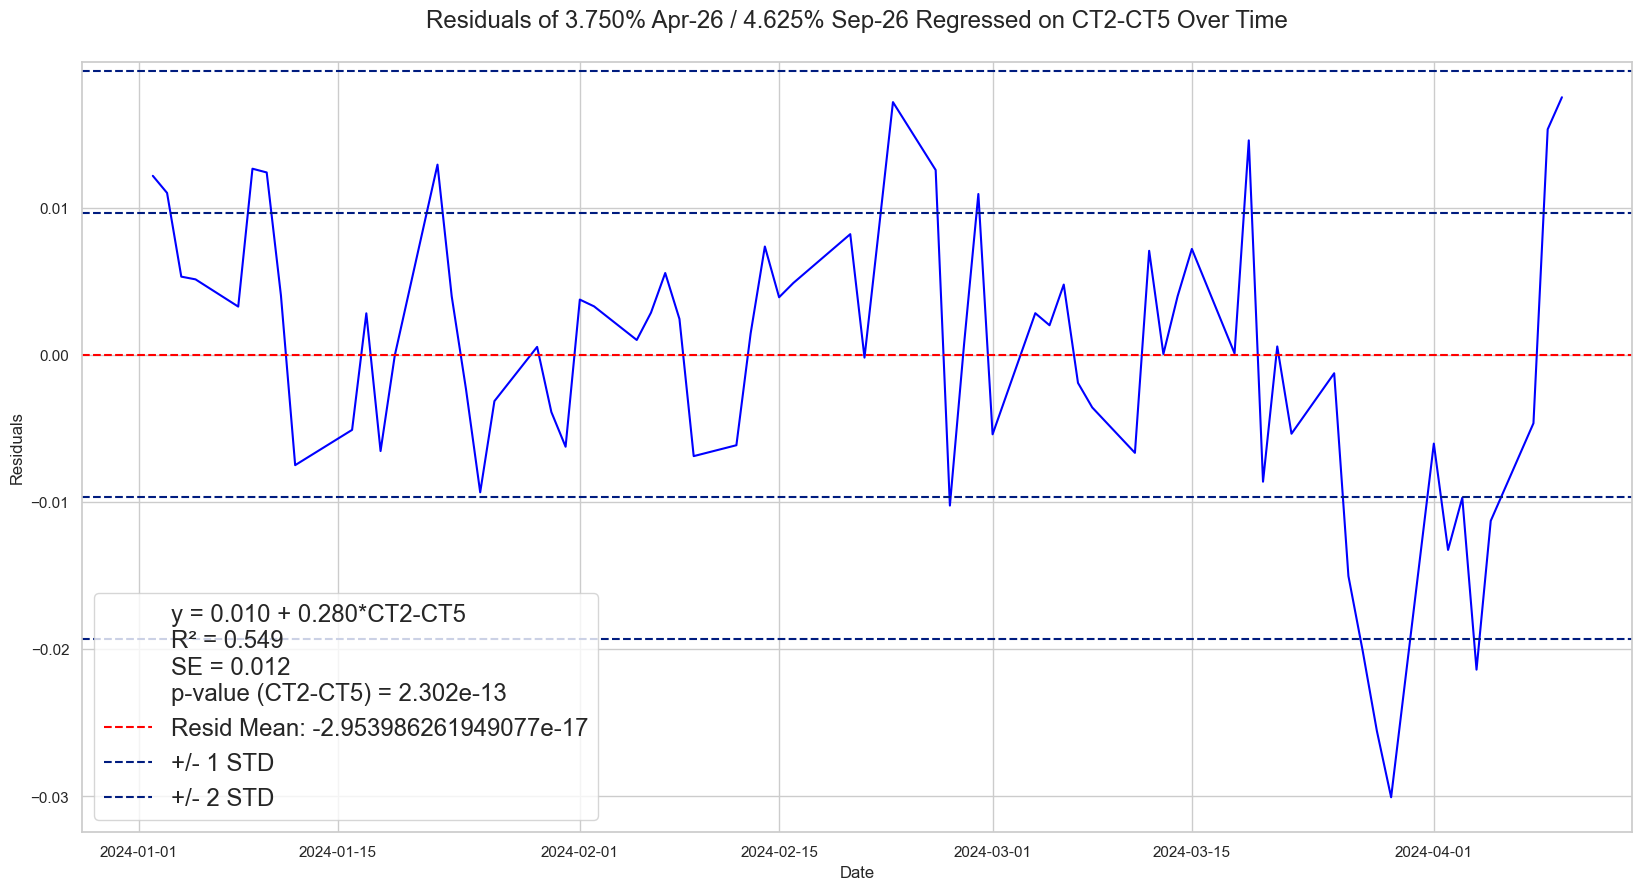

Using lpf_cubic_spline for UST Metrics Calcs


3.750% Apr-26 Metrics Calc: 70it [00:02, 30.85it/s]
4.625% Sep-26 Metrics Calc: 70it [00:01, 37.84it/s]


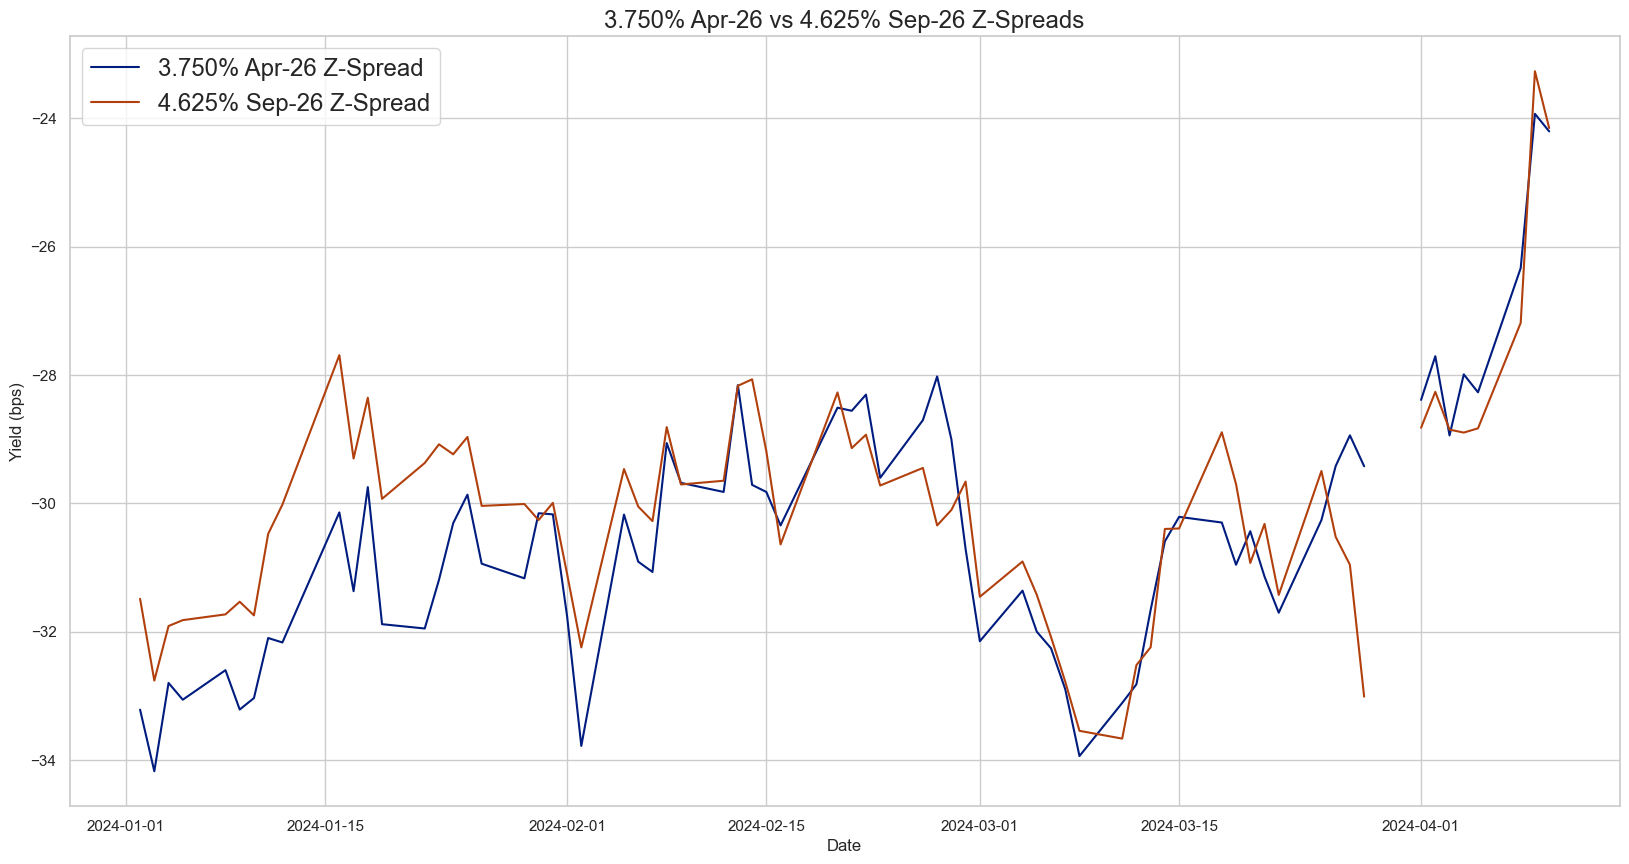

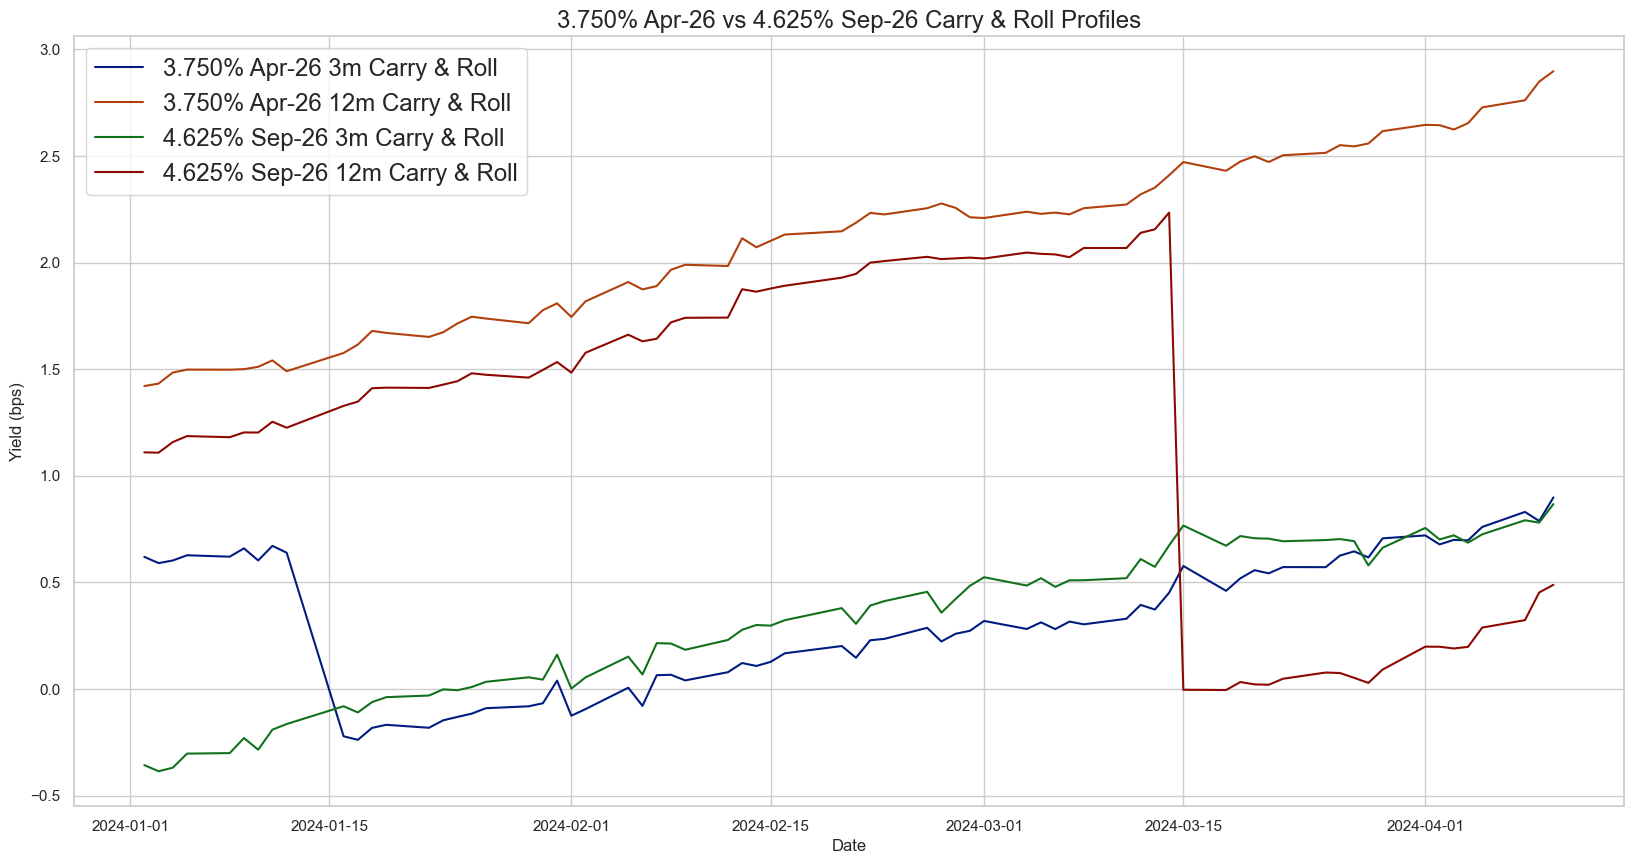

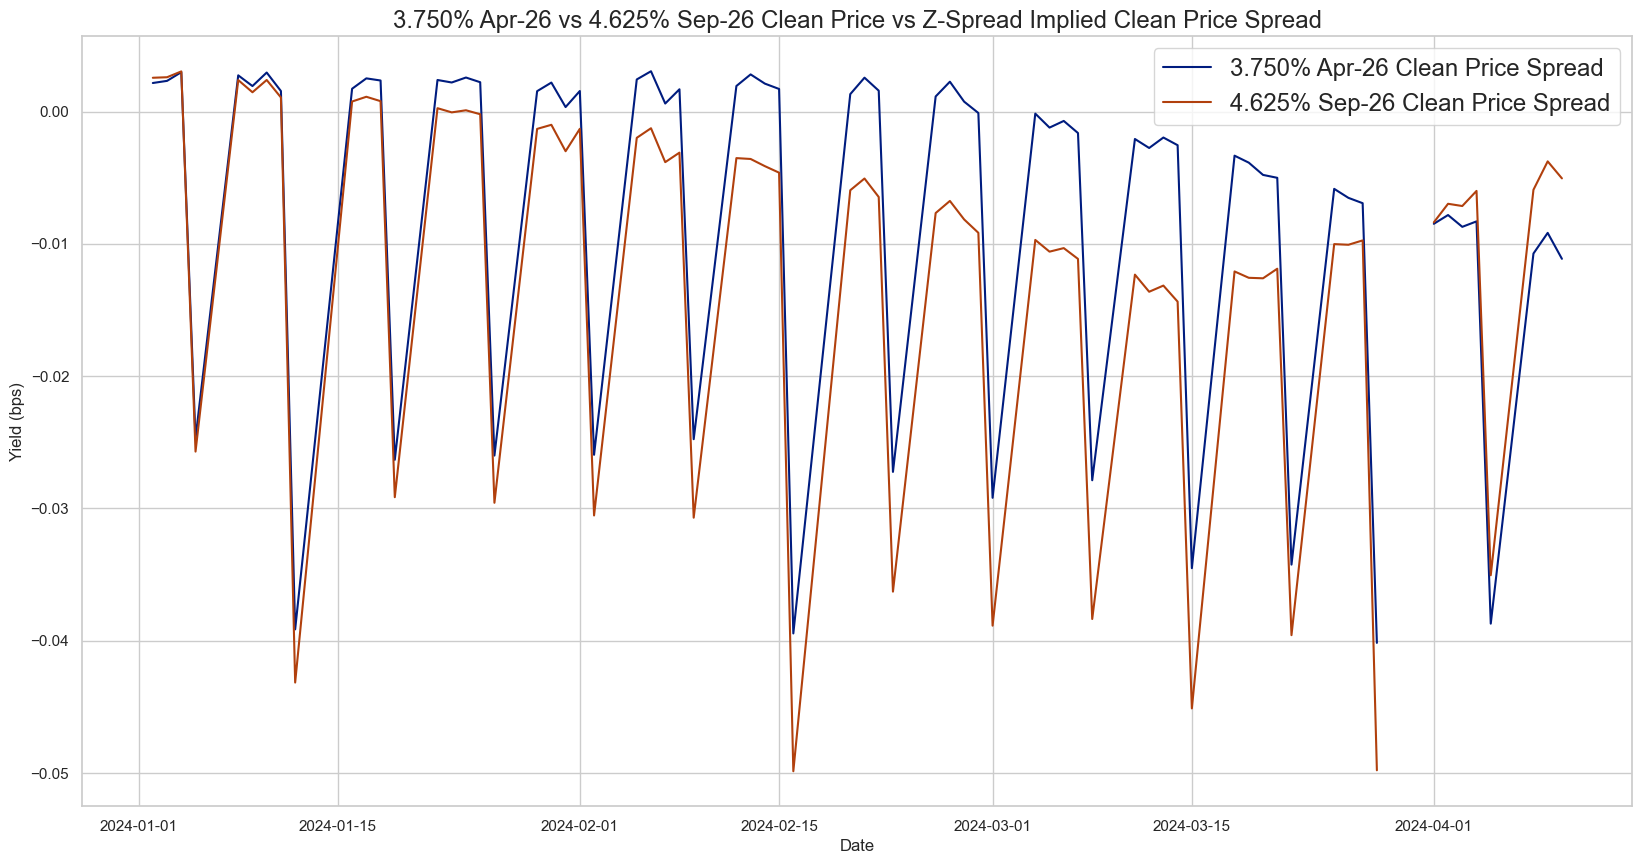

In [56]:
label1 = "3.750% Apr-26" 
label2 = "4.625% Sep-26" 

cusip_spread_rv_regression(
    curve_data_fetcher=curve_data_fetcher,
    label1=label1,
    label2=label2,
    cusip_timeseries=cusip_timeseries,
    fitted_splines_timeseries_dict={
        "lpf_cubic_spline": fitted_cubic_spline_timeseries,
        "lpf_bspline": fitted_bspline_timeseries,
        "lpf_smooth_spline": fitted_smooth_spline_timeseries,
    },
    benchmark_tenor_1=2,
    benchmark_tenor_2=5,
    ct_yields_df=ct_yields_df,
)